In [1]:
%matplotlib inline 
#%load_ext autoreload 
%reload_ext autoreload
%autoreload 2
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

from __future__ import (division, 
                        print_function)

import os
import sys
import copy

import h5py
import numpy as np
import scipy
from scipy.interpolate import interp1d

from astropy.io import fits
from astropy import units as u
from astropy.stats import sigma_clip
from astropy.table import Table, Column
from astropy.utils.console import ProgressBar
from astropy.convolution import convolve, Box1DKernel


import matplotlib as mpl
import matplotlib.mlab as ml
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
from matplotlib.patches import Ellipse
from matplotlib.ticker import NullFormatter, MaxNLocator, FormatStrFormatter
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
tickFormat = FormatStrFormatter('$\mathbf{%g}$') 
mpl.rcParams.update({'xtick.color': 'k'})
mpl.rcParams.update({'ytick.color': 'k'})
mpl.rcParams.update({'font.size': 20})

import cosmology
c=cosmology.Cosmo(H0=70.0, omega_m=0.3, omega_l=0.7, flat=1)


import sys
sys.path.append('/Users/RAJ/github/kungpao')
from kungpao.galsbp import galSBP
from kungpao.display import display_single, random_cmap
import statsmodels.api as sm
from scipy.interpolate import interp1d 
from kungpao import io
from kungpao import utils
from kungpao import detection
from kungpao import imtools

import sep
from palettable.colorbrewer.sequential import Greys_9, OrRd_9, Blues_9, Purples_9, YlGn_9
BLK = Greys_9.mpl_colormap
ORG = OrRd_9.mpl_colormap
BLU = Blues_9.mpl_colormap
GRN = YlGn_9.mpl_colormap

/Users/RAJ/anaconda/envs/illustris_profiles/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Users/RAJ/anaconda/envs/illustris_profiles/lib/python2.7/site-packages/pyraf/irafimport.py:116: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  retval = _originalImport(name, globals, locals, fromlist, level)


In [2]:
from pylab import figure, text, scatter, show

In [3]:
from pyraf import iraf

iraf.tables()
iraf.stsdas()
iraf.analysis()
iraf.isophote()

iraf.unlearn('ellipse')
iraf.unlearn('bmodel')



      +------------------------------------------------------------+
      |             Space Telescope Tables Package                 |    
      |                  TABLES Version 3.17                       |
      |                                                            |
      |   Space Telescope Science Institute, Baltimore, Maryland   |
      |   Copyright (C) 2014 Association of Universities for       |
      |            Research in Astronomy, Inc.(AURA)               |
      |       See stsdas$copyright.stsdas for terms of use.        |
      |         For help, send e-mail to help@stsci.edu            |
      +------------------------------------------------------------+
tables/:
 fitsio/        tbplot/         tobsolete/      ttools/


      +------------------------------------------------------------+
      |       Space Telescope Science Data Analysis System         |    
      |                   STSDAS Version 3.17                      |
      |                   

In [4]:
IMG_CMAP = plt.get_cmap('viridis')
IMG_CMAP.set_bad(color='black')

SEG_CMAP = random_cmap(ncolors=512, background_color=u'white')
SEG_CMAP.set_bad(color='white')
SEG_CMAP.set_under(color='white')

In [5]:
illustris_direc_high = '/Users/RAJ/summer_work_2018/notebook_tng/high_res'
illustris_direc_quick = '/Users/RAJ/summer_work_2018/notebook_tng/quick'
illustris_direc_metal = '/Users/RAJ/summer_work_2018/notebook_tng/high_res/metal'
illustris_direc_age = '/Users/RAJ/summer_work_2018/notebook_tng/high_res/age'

In [6]:
illustris_maps_high = np.load(os.path.join(illustris_direc_high,'illustris_high_maps.npy'))
illustris_maps_quick = np.load(os.path.join(illustris_direc_quick,'illustris_quick_maps.npy'))

In [7]:
illustris_maps_high_metalicity = np.load(os.path.join(illustris_direc_metal, 'Illustris_maps_high_metal.npy'))
illustris_maps_high_age = np.load(os.path.join(illustris_direc_age, 'Illustris_maps_high_age.npy'))


In [15]:
illustris_0_ell_high = np.load(os.path.join(illustris_direc_high,'illustris_0_ell_high.npy'))
illustris_ell_quick = np.load(os.path.join(illustris_direc_quick,'illustris_0_ell_quick.npy'))

In [17]:
illustris_high_file_hdf5='/Users/RAJ/summer_work_2018/notebook_tng/high_res/galaxies_tng100_072_agez_highres.hdf5'


In [20]:
illustris_quick_file_hdf5='/Users/RAJ/summer_work_2018/notebook_tng/quick/galaxies_tng100_072_agez_lowres.hdf5'

In [22]:
illustris_file = h5py.File(illustris_quick_file_hdf5, 'r')

In [32]:
def get_ngalaxies(file):
    f = h5py.File(file, 'r')
    n_galaxies = len(f['catsh_id'])
    return n_galaxies

In [34]:
n_galaxies = get_ngalaxies(illustris_quick_file_hdf5)
print (n_galaxies)

296


In [23]:
cat_sh_mstar=np.array(illustris_file['catsh_SubhaloMassType'][:, 4])
logms_cat = np.log10(cat_sh_mstar)

In [24]:
mask_bin1 = ((logms_cat >= 11.4) & (logms_cat < 11.5) )
mask_bin2 = ((logms_cat >= 11.5) & (logms_cat < 11.6)  )
mask_bin3 = ((logms_cat >= 11.6) & (logms_cat < 11.7)   )
mask_bin4 = ((logms_cat >= 11.7) & (logms_cat < 11.85) )
mask_bin5 = ((logms_cat >= 11.85) & (logms_cat < 12.4) )

In [64]:
high_bin_1 = illustris_0_ell_high[mask_bin1]
high_bin_2 = illustris_0_ell_high[mask_bin2]
high_bin_3 = illustris_0_ell_high[mask_bin3]
high_bin_4 = illustris_0_ell_high[mask_bin4]
high_bin_5 = illustris_0_ell_high[mask_bin5]

In [65]:
age_high_bin_1_maps = illustris_maps_high_age[mask_bin1]
age_high_bin_2_maps = illustris_maps_high_age[mask_bin2]
age_high_bin_3_maps = illustris_maps_high_age[mask_bin3]
age_high_bin_4_maps = illustris_maps_high_age[mask_bin4]
age_high_bin_5_maps = illustris_maps_high_age[mask_bin5]

In [66]:
metal_high_bin_1_maps = illustris_maps_high_metalicity[mask_bin1]
metal_high_bin_2_maps = illustris_maps_high_metalicity[mask_bin2]
metal_high_bin_3_maps = illustris_maps_high_metalicity[mask_bin3]
metal_high_bin_4_maps = illustris_maps_high_metalicity[mask_bin4]
metal_high_bin_5_maps = illustris_maps_high_metalicity[mask_bin5]

# for bin 1 : 6 is problematic

# cell below quick refers to high

In [155]:
def generate_profiles(image_map,ell_file,type_):
    x0 = ell_file[type_]['x0'][1:]
    y0 = ell_file[type_]['y0'][1:]
    theta = ell_file[type_]['pa'][1:] * np.pi / 180.0
    a = ell_file[type_]['sma'][1:]  * (1.0 - ell_file[type_]['ell'][1:])
    b = ell_file[type_]['sma'][1:] 
    img_to_extract = image_map
    m,n = img_to_extract.shape
    sma= []
    std_arr = []
    mean_arr = [] 
    for i in range(len(x0)-25): 
        mask_inner = np.zeros((m,n), dtype=np.bool)
        mask_outer = np.zeros((m,n), dtype=np.bool)
        sep.mask_ellipse(mask_inner, x0[i+20], y0[i+20], a[i+20], b[i+20], theta[i+20])
        sep.mask_ellipse(mask_outer, x0[i+25], y0[i+25], a[i+25], b[i+25], theta[i+25])
        pixels_in_mask = (np.multiply(img_to_extract, np.logical_and(mask_outer, ~mask_inner)))
        mean = np.nanmean(pixels_in_mask[pixels_in_mask > 0.])
        std = np.nanstd(pixels_in_mask[pixels_in_mask > 0.])
        sma.append(( b[i+20]+ b[i+25])/2)
        std_arr.append(std)
        mean_arr.append(mean)
    return np.array(sma),np.array(mean_arr),np.array(std_arr)

In [199]:
def get_median_am(gal_list,ell_list,ins_exs,kind,rmin=0.5, rmax=120, nbin=700):
    """Get the median ellipticity profiles."""
    if ins_exs == 'insitu':
        j = 1
    else:
        j = 2
        
    rsma_common = np.linspace(rmin, rmax, nbin)
    a11,b11,c11 = generate_profiles(gal_list[0][j],ell_list[0],kind)
    stacked = interp1d((a11) , (b11),
                                    bounds_error=False, 
                                    fill_value=np.nan, 
                                    kind='slinear')(rsma_common)
    
    for i in range(len(gal_list)-1):
        a1,b1,c1 = generate_profiles(gal_list[i+1][j],ell_list[i+1],kind)
        stacking  = interp1d((a1) ,(b1),
                                    bounds_error=False, 
                                    fill_value=np.nan, 
                                    kind='slinear')(rsma_common)
        stacked = np.vstack((stacked, stacking))
        
    return np.nanmedian(stacked,axis = 0)
        

        

    
 
    

In [200]:
rsma_common = np.linspace(0.5, 120, 700)

/Users/RAJ/anaconda/envs/illustris_profiles/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice


[]

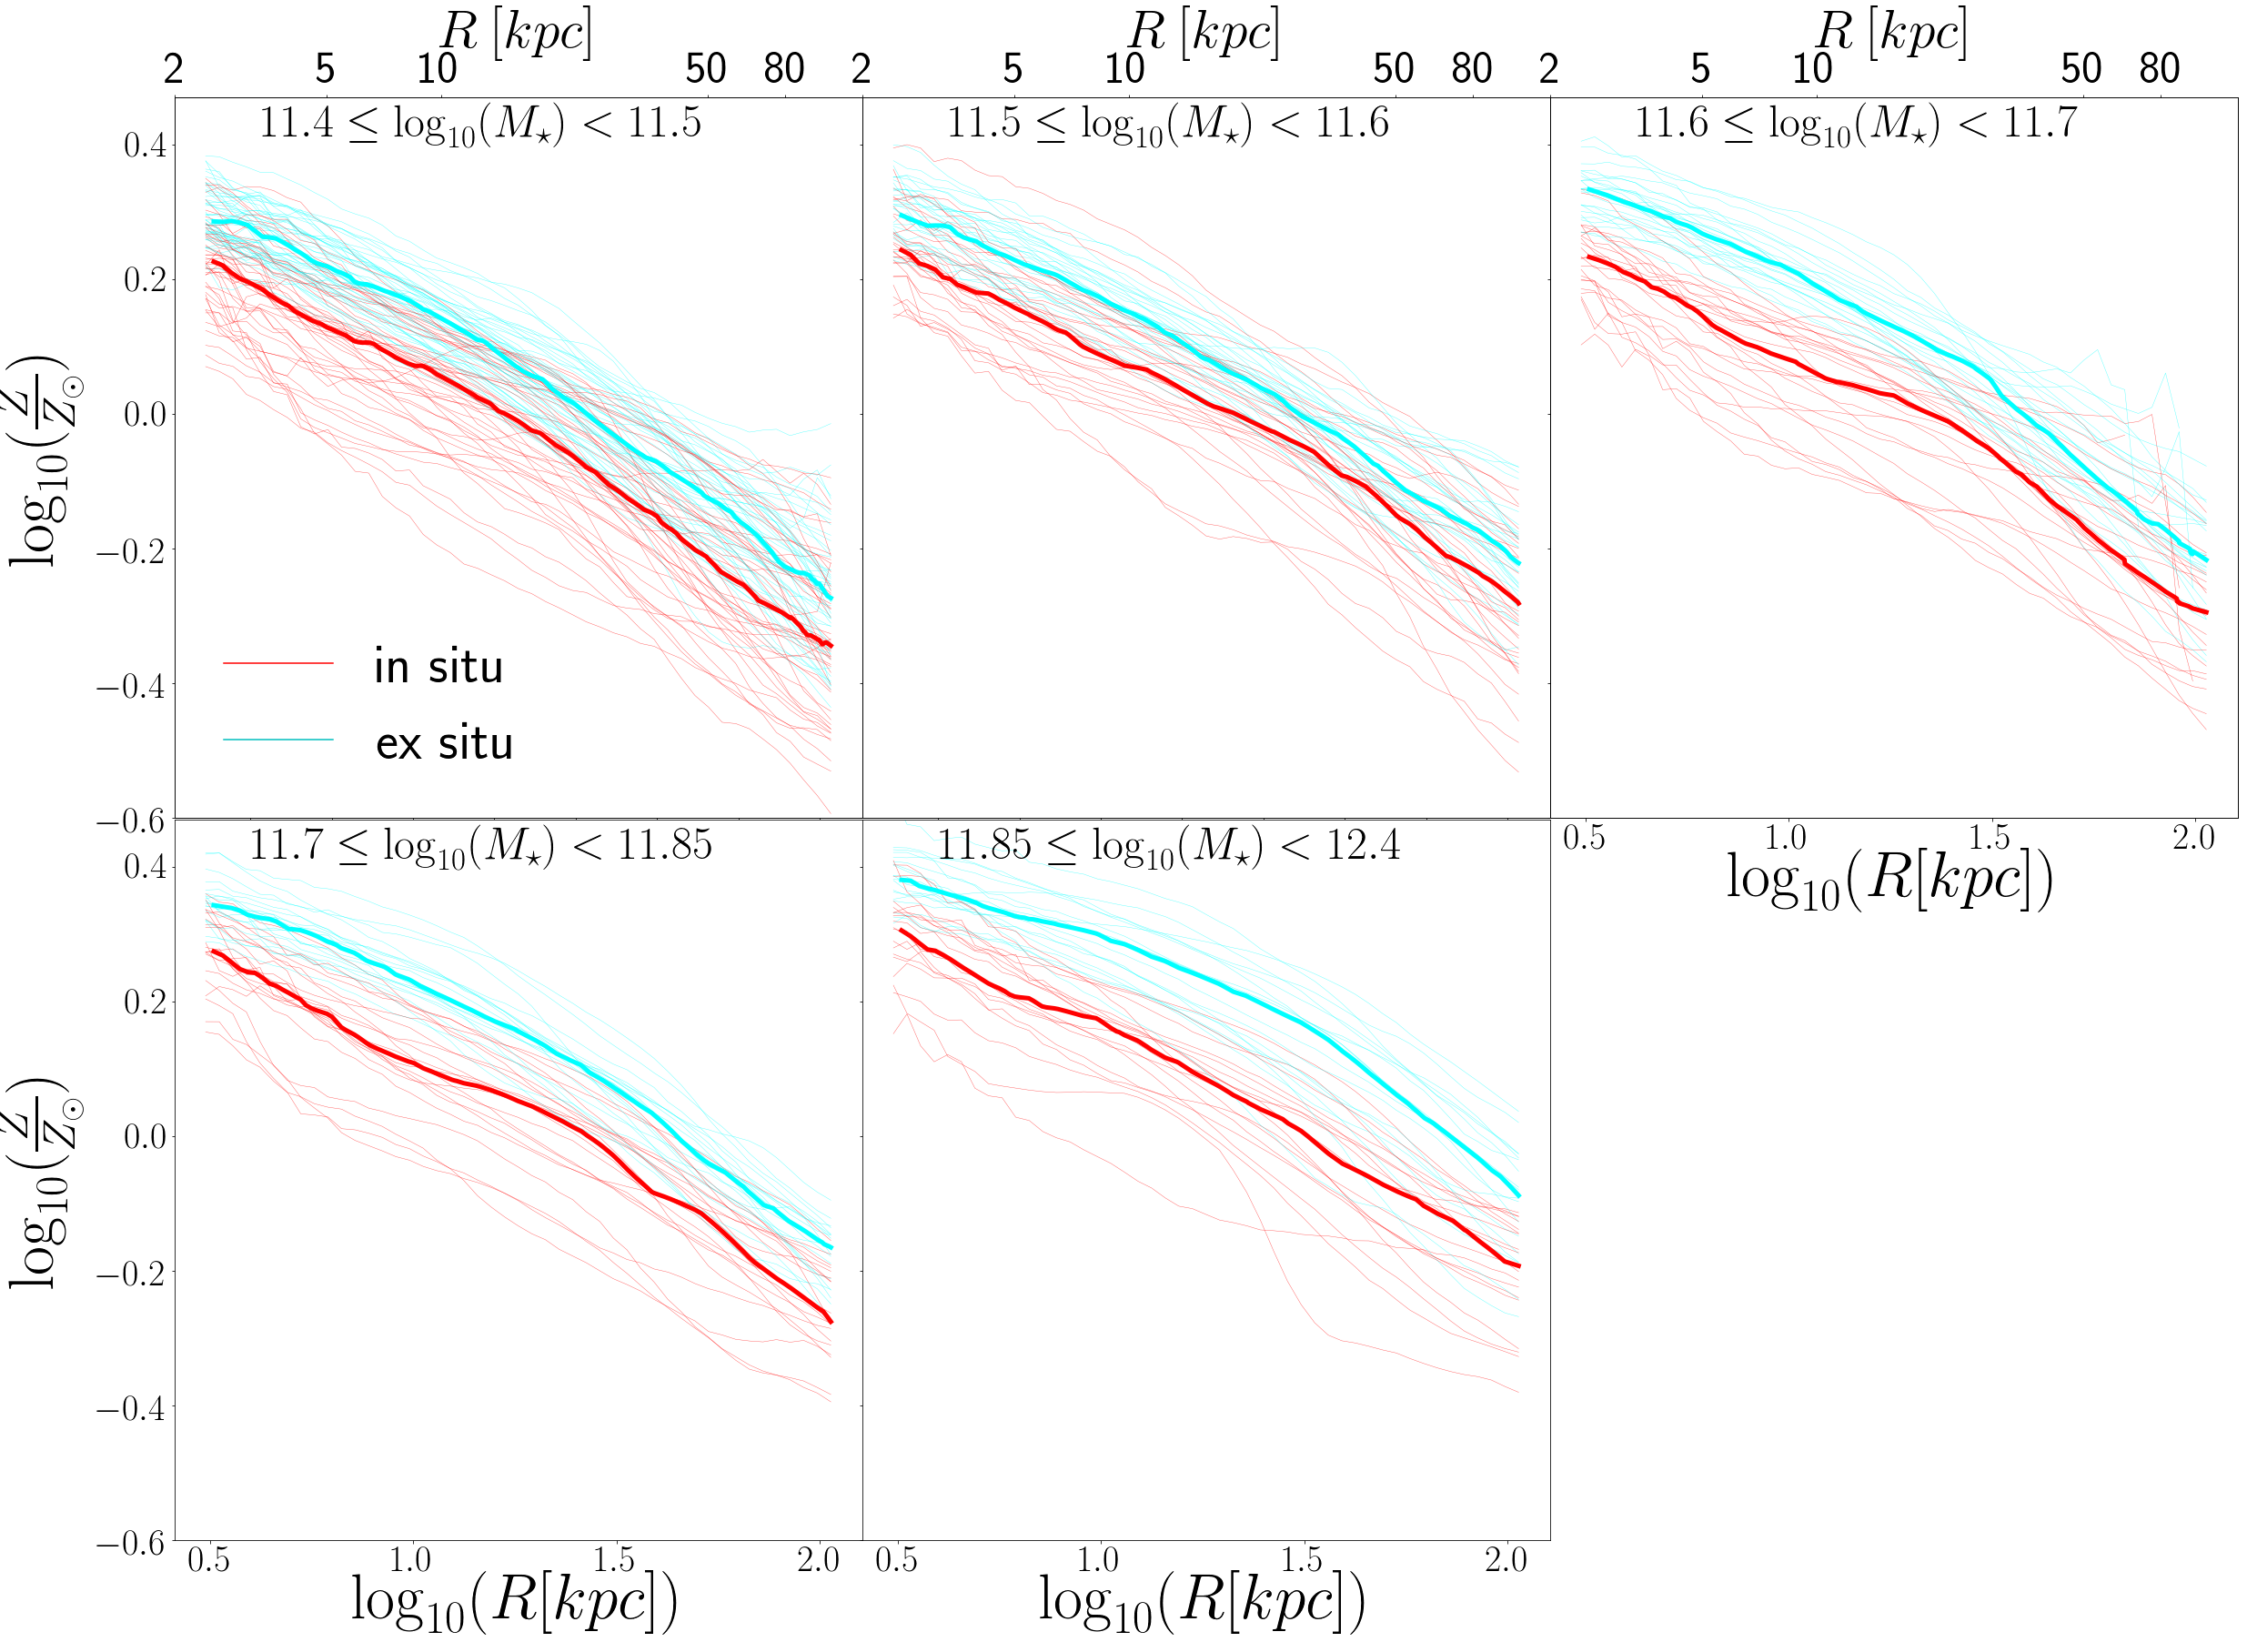

In [212]:
fig = plt.figure(figsize=(35, 22))
ax1 = plt.axes([0.1,0.55,0.3,0.5])
ax2 = plt.axes([0.4,0.55,0.3,0.5])
ax3 = plt.axes([0.7,0.55,0.3,0.5])
ax4 = plt.axes([0.1,0.049,0.3,0.5])
ax5 = plt.axes([0.4,0.049,0.3,0.5])
for i in range(len(metal_high_bin_1_maps)):
    if i != 6: # this is because 6 was problematic
        a1,b1,c1 = generate_profiles(metal_high_bin_1_maps[i][1],high_bin_1[i],'ell_ins_3')
        #a2,b2,c2 = generate_profiles(age_high_bin_1_maps[i][1],high_bin_1[i],'ell_ins_3')
        a11,b11,c11 = generate_profiles(metal_high_bin_1_maps[i][2],high_bin_1[i],'ell_exs_3')
        #a22,b22,c22 = generate_profiles(age_high_bin_1_maps[i][2],high_bin_1[i],'ell_exs_3')
        b1 = np.array(b1)
        b11 = np.array(b11)
        ax1.plot(np.log10(a1),np.log10(b1/0.0134),label = 'metallicity',color = 'r',linewidth = 0.4,alpha = 0.7)
        ax1.plot(np.log10(a11),np.log10(b11/0.0134),label = 'metallicity',color = 'cyan',linewidth = 0.4,alpha = 0.7)
        ax1.set_ylabel(r'$ \log_{10}(\frac{Z}{Z_{\odot}}) $',fontsize = 40)
        ax1.set_xlabel(r'$ \log_{10}(R[kpc]) $',fontsize = 40)
med_bin_1_ins = get_median_am(metal_high_bin_1_maps,high_bin_1,'insitu','ell_ins_3')
med_bin_1_exs = get_median_am(metal_high_bin_1_maps,high_bin_1,'exsitu','ell_exs_3')
ax1.plot(np.log10(rsma_common),np.log10(med_bin_1_ins/0.0134),label = 'metallicity',color = 'r',linewidth = 5)
ax1.plot(np.log10(rsma_common),np.log10(med_bin_1_exs/0.0134),label = 'metallicity',color = 'cyan',linewidth = 5)


x1, x2 = ax1.get_xlim()
ax1_twin = ax1.twiny()
ax1_twin.set_xlim(x1, x2)
ax1_twin.figure.canvas.draw()
ax1_twin.xaxis.set_ticks([np.log10(2), np.log10(5), np.log10(10), np.log10(50),np.log10(80)])
ax1_twin.xaxis.set_ticklabels([2, 5, 10, 50,80])
ax1_twin.tick_params(axis='both', which='major', labelsize=50)
ax1_twin.set_xlabel(r'$R \: [kpc]$', fontsize=60)
text(0.45, 0.95,'$11.4 \leq \log_{10 }(M_{\star})<11.5$',fontsize =50,
     horizontalalignment='center',
     verticalalignment='center',transform=ax1.transAxes)
red_line = mlines.Line2D([], [], color='r',
                          markersize=15, label='in situ')
cyan_line = mlines.Line2D([], [], color='c',
                          markersize=45, label='ex situ')
ax1.legend(handles=[red_line,cyan_line],loc=3,fontsize =60,frameon=False)
ax1.set_xticklabels([])
ax1.tick_params(axis='y', which='major', labelsize=40)
#ax1.set_xlim(0.5,2.3)
#ax1.set_ylim(2.0,10.1)
#ax1.set_xlabel(r'$\log (R[kpc]) $',fontsize = 40)
ax1.set_ylabel(r'$ \log_{10}(\frac{Z}{Z_{\odot}}) $',fontsize = 70)
ax1.yaxis.set_major_locator(plt.MaxNLocator(6))
ax1.set_ylim(-0.6,0.47)


for i in range(len(metal_high_bin_2_maps)):
    
    a1,b1,c1 = generate_profiles(metal_high_bin_2_maps[i][1],high_bin_2[i],'ell_ins_3')
    #a2,b2,c2 = generate_profiles(age_high_bin_1_maps[i][1],high_bin_1[i],'ell_ins_3')
    a11,b11,c11 = generate_profiles(metal_high_bin_2_maps[i][2],high_bin_2[i],'ell_exs_3')
        #a22,b22,c22 = generate_profiles(age_high_bin_1_maps[i][2],high_bin_1[i],'ell_exs_3')
    b1 = np.array(b1)
    b11 = np.array(b11)
    ax2.plot(np.log10(a1),np.log10(b1/0.0134),label = 'metallicity',color = 'r',linewidth = 0.4,alpha = 0.7)
    ax2.plot(np.log10(a11),np.log10(b11/0.0134),label = 'metallicity',color = 'cyan',linewidth = 0.4,alpha = 0.7)
        #ax1.set_ylabel(r'$ \log_{10}(\frac{Z}{Z_{\odot}}) $',fontsize = 40)
    ax2.set_xlabel(r'$ \log_{10}(R[kpc]) $',fontsize = 40)
med_bin_2_ins = get_median_am(metal_high_bin_2_maps,high_bin_1,'insitu','ell_ins_3')
med_bin_2_exs = get_median_am(metal_high_bin_2_maps,high_bin_1,'exsitu','ell_exs_3')
ax2.plot(np.log10(rsma_common),np.log10(med_bin_2_ins/0.0134),label = 'metallicity',color = 'r',linewidth = 5)
ax2.plot(np.log10(rsma_common),np.log10(med_bin_2_exs/0.0134),label = 'metallicity',color = 'cyan',linewidth = 5)
x1, x2 = ax2.get_xlim()
ax2_twin = ax2.twiny()
ax2_twin.set_xlim(x1, x2)
ax2_twin.figure.canvas.draw()
ax2_twin.xaxis.set_ticks([np.log10(2), np.log10(5), np.log10(10), np.log10(50),np.log10(80)])
ax2_twin.xaxis.set_ticklabels([2, 5, 10, 50,80])
ax2_twin.tick_params(axis='both', which='major', labelsize=50)
ax2_twin.set_xlabel(r'$R \: [kpc]$', fontsize=60)

text(0.45, 0.95,'$11.5 \leq \log_{10 }(M_{\star})<11.6$',fontsize =50,
     horizontalalignment='center',
     verticalalignment='center',transform=ax2.transAxes)
#ax2.set_xlim(0.5,2.3)
ax2.set_xticklabels([])
ax2.set_yticklabels([])
#ax2.set_xlabel(r'$\log (R[kpc]) $',fontsize = 30)
#ax2.set_ylabel(r'$\log\ (\mu_{\star}/[M_{\odot}\ \mathrm{kpc}^{-2}])$',fontsize = 50)
ax2.set_ylim(-0.6,0.47)

for i in range(len(metal_high_bin_3_maps)):
    
    a1,b1,c1 = generate_profiles(metal_high_bin_3_maps[i][1],high_bin_3[i],'ell_ins_3')
    #a2,b2,c2 = generate_profiles(age_high_bin_1_maps[i][1],high_bin_1[i],'ell_ins_3')
    a11,b11,c11 = generate_profiles(metal_high_bin_3_maps[i][2],high_bin_3[i],'ell_exs_3')
        #a22,b22,c22 = generate_profiles(age_high_bin_1_maps[i][2],high_bin_1[i],'ell_exs_3')
    b1 = np.array(b1)
    b11 = np.array(b11)
    ax3.plot(np.log10(a1),np.log10(b1/0.0134),label = 'metallicity',color = 'r',linewidth = 0.4,alpha = 0.7)
    ax3.plot(np.log10(a11),np.log10(b11/0.0134),label = 'metallicity',color = 'cyan',linewidth = 0.4,alpha = 0.7)
        #ax1.set_ylabel(r'$ \log_{10}(\frac{Z}{Z_{\odot}}) $',fontsize = 40)
    ax3.set_xlabel(r'$ \log_{10}(R[kpc]) $',fontsize = 40)
med_bin_3_ins = get_median_am(metal_high_bin_3_maps,high_bin_3,'insitu','ell_ins_3')
med_bin_3_exs = get_median_am(metal_high_bin_3_maps,high_bin_3,'exsitu','ell_exs_3')
ax3.plot(np.log10(rsma_common),np.log10(med_bin_3_ins/0.0134),label = 'metallicity',color = 'r',linewidth = 5)
ax3.plot(np.log10(rsma_common),np.log10(med_bin_3_exs/0.0134),label = 'metallicity',color = 'cyan',linewidth = 5)
x1, x2 = ax3.get_xlim()
ax3_twin = ax3.twiny()
ax3_twin.set_xlim(x1, x2)
ax3_twin.figure.canvas.draw()
ax3_twin.xaxis.set_ticks([np.log10(2), np.log10(5), np.log10(10), np.log10(50),np.log10(80)])
ax3_twin.xaxis.set_ticklabels([2, 5, 10, 50,80])
ax3_twin.tick_params(axis='both', which='major',  labelsize=50)
ax3_twin.set_xlabel(r'$R \: [kpc]$', fontsize=60)
ax3.set_ylim(-0.6,0.47)
text(0.45, 0.95,'$11.6 \leq \log_{10 }(M_{\star})<11.7$',fontsize= 50,
     horizontalalignment='center',
     verticalalignment='center',transform=ax3.transAxes)
ax3.set_yticklabels([])
ax3.set_xlabel(r'$\log_{10 } (R[kpc]) $',fontsize = 70)
#ax3.set_ylabel(r'$\log\ (\mu_{\star}/[M_{\odot}\ \mathrm{kpc}^{-2}])$',fontsize = 30)
ax3.tick_params(axis='x', which='major', labelsize=40)

for i in range(len(metal_high_bin_4_maps)):
    
    a1,b1,c1 = generate_profiles(metal_high_bin_4_maps[i][1],high_bin_4[i],'ell_ins_3')
    #a2,b2,c2 = generate_profiles(age_high_bin_1_maps[i][1],high_bin_1[i],'ell_ins_3')
    a11,b11,c11 = generate_profiles(metal_high_bin_4_maps[i][2],high_bin_4[i],'ell_exs_3')
        #a22,b22,c22 = generate_profiles(age_high_bin_1_maps[i][2],high_bin_1[i],'ell_exs_3')
    b1 = np.array(b1)
    b11 = np.array(b11)
    ax4.plot(np.log10(a1),np.log10(b1/0.0134),label = 'metallicity',color = 'r',linewidth = 0.4,alpha = 0.7)
    ax4.plot(np.log10(a11),np.log10(b11/0.0134),label = 'metallicity',color = 'cyan',linewidth = 0.4,alpha = 0.7)
        #ax1.set_ylabel(r'$ \log_{10}(\frac{Z}{Z_{\odot}}) $',fontsize = 40)
    ax4.set_xlabel(r'$ \log_{10}(R[kpc]) $',fontsize = 40)

text(0.45, 0.95,'$11.7 \leq \log_{10 }(M_{\star})<11.85$',fontsize= 50,
     horizontalalignment='center',
     verticalalignment='center',transform=ax4.transAxes)
med_bin_4_ins = get_median_am(metal_high_bin_4_maps,high_bin_4,'insitu','ell_ins_3')
med_bin_4_exs = get_median_am(metal_high_bin_4_maps,high_bin_4,'exsitu','ell_exs_3')
ax4.plot(np.log10(rsma_common),np.log10(med_bin_4_ins/0.0134),label = 'metallicity',color = 'r',linewidth = 5)
ax4.plot(np.log10(rsma_common),np.log10(med_bin_4_exs/0.0134),label = 'metallicity',color = 'cyan',linewidth = 5)
#ax4.set_xlim(0.5,2.3)
ax4.set_xlabel(r'$\log_{10 } (R[kpc]) $',fontsize = 70)
ax4.set_ylabel(r'$ \log_{10}(\frac{Z}{Z_{\odot}}) $',fontsize = 70)
ax4.tick_params(axis='y', which='major', labelsize=40)
ax4.tick_params(axis='x', which='major', labelsize=40)
ax4.yaxis.set_major_locator(plt.MaxNLocator(6))
ax4.set_ylim(-0.6,0.47)
for i in range(len(metal_high_bin_5_maps)):
    
    a1,b1,c1 = generate_profiles(metal_high_bin_5_maps[i][1],high_bin_5[i],'ell_ins_3')
    #a2,b2,c2 = generate_profiles(age_high_bin_1_maps[i][1],high_bin_1[i],'ell_ins_3')
    a11,b11,c11 = generate_profiles(metal_high_bin_5_maps[i][2],high_bin_5[i],'ell_exs_3')
        #a22,b22,c22 = generate_profiles(age_high_bin_1_maps[i][2],high_bin_1[i],'ell_exs_3')
    b1 = np.array(b1)
    b11 = np.array(b11)
    ax5.plot(np.log10(a1),np.log10(b1/0.0134),label = 'metallicity',color = 'r',linewidth = 0.4,alpha = 0.7)
    ax5.plot(np.log10(a11),np.log10(b11/0.0134),label = 'metallicity',color = 'cyan',linewidth = 0.4,alpha = 0.7)
        #ax1.set_ylabel(r'$ \log_{10}(\frac{Z}{Z_{\odot}}) $',fontsize = 40)
    ax5.set_xlabel(r'$ \log_{10}(R[kpc]) $',fontsize = 40)
med_bin_5_ins = get_median_am(metal_high_bin_5_maps,high_bin_5,'insitu','ell_ins_3')
med_bin_5_exs = get_median_am(metal_high_bin_5_maps,high_bin_5,'exsitu','ell_exs_3')
ax5.plot(np.log10(rsma_common),np.log10(med_bin_5_ins/0.0134),label = 'metallicity',color = 'r',linewidth = 5)
ax5.plot(np.log10(rsma_common),np.log10(med_bin_5_exs/0.0134),label = 'metallicity',color = 'cyan',linewidth = 5)
ax5.set_ylim(-0.6,0.47)
text(0.45, 0.95,'$11.85 \leq \log_{10 }(M_{\star})<12.4$',fontsize = 50,
     horizontalalignment='center',
     verticalalignment='center',transform=ax5.transAxes)
#ax5.set_xlim(0.5,2.3)
ax5.set_xlabel(r'$\log_{10 } (R[kpc]) $',fontsize = 70)
ax5.tick_params(axis='x', which='major', labelsize=40)
ax5.tick_params(axis='x', which='major', labelsize=40)


#ax5.set_ylabel(r'$\log\ (\mu_{\star}/[M_{\odot}\ \mathrm{kpc}^{-2}])$',fontsize = 30)
ax5.set_yticklabels([])
#ax5.set_xticksize(20)



/Users/RAJ/anaconda/envs/illustris_profiles/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice


[]

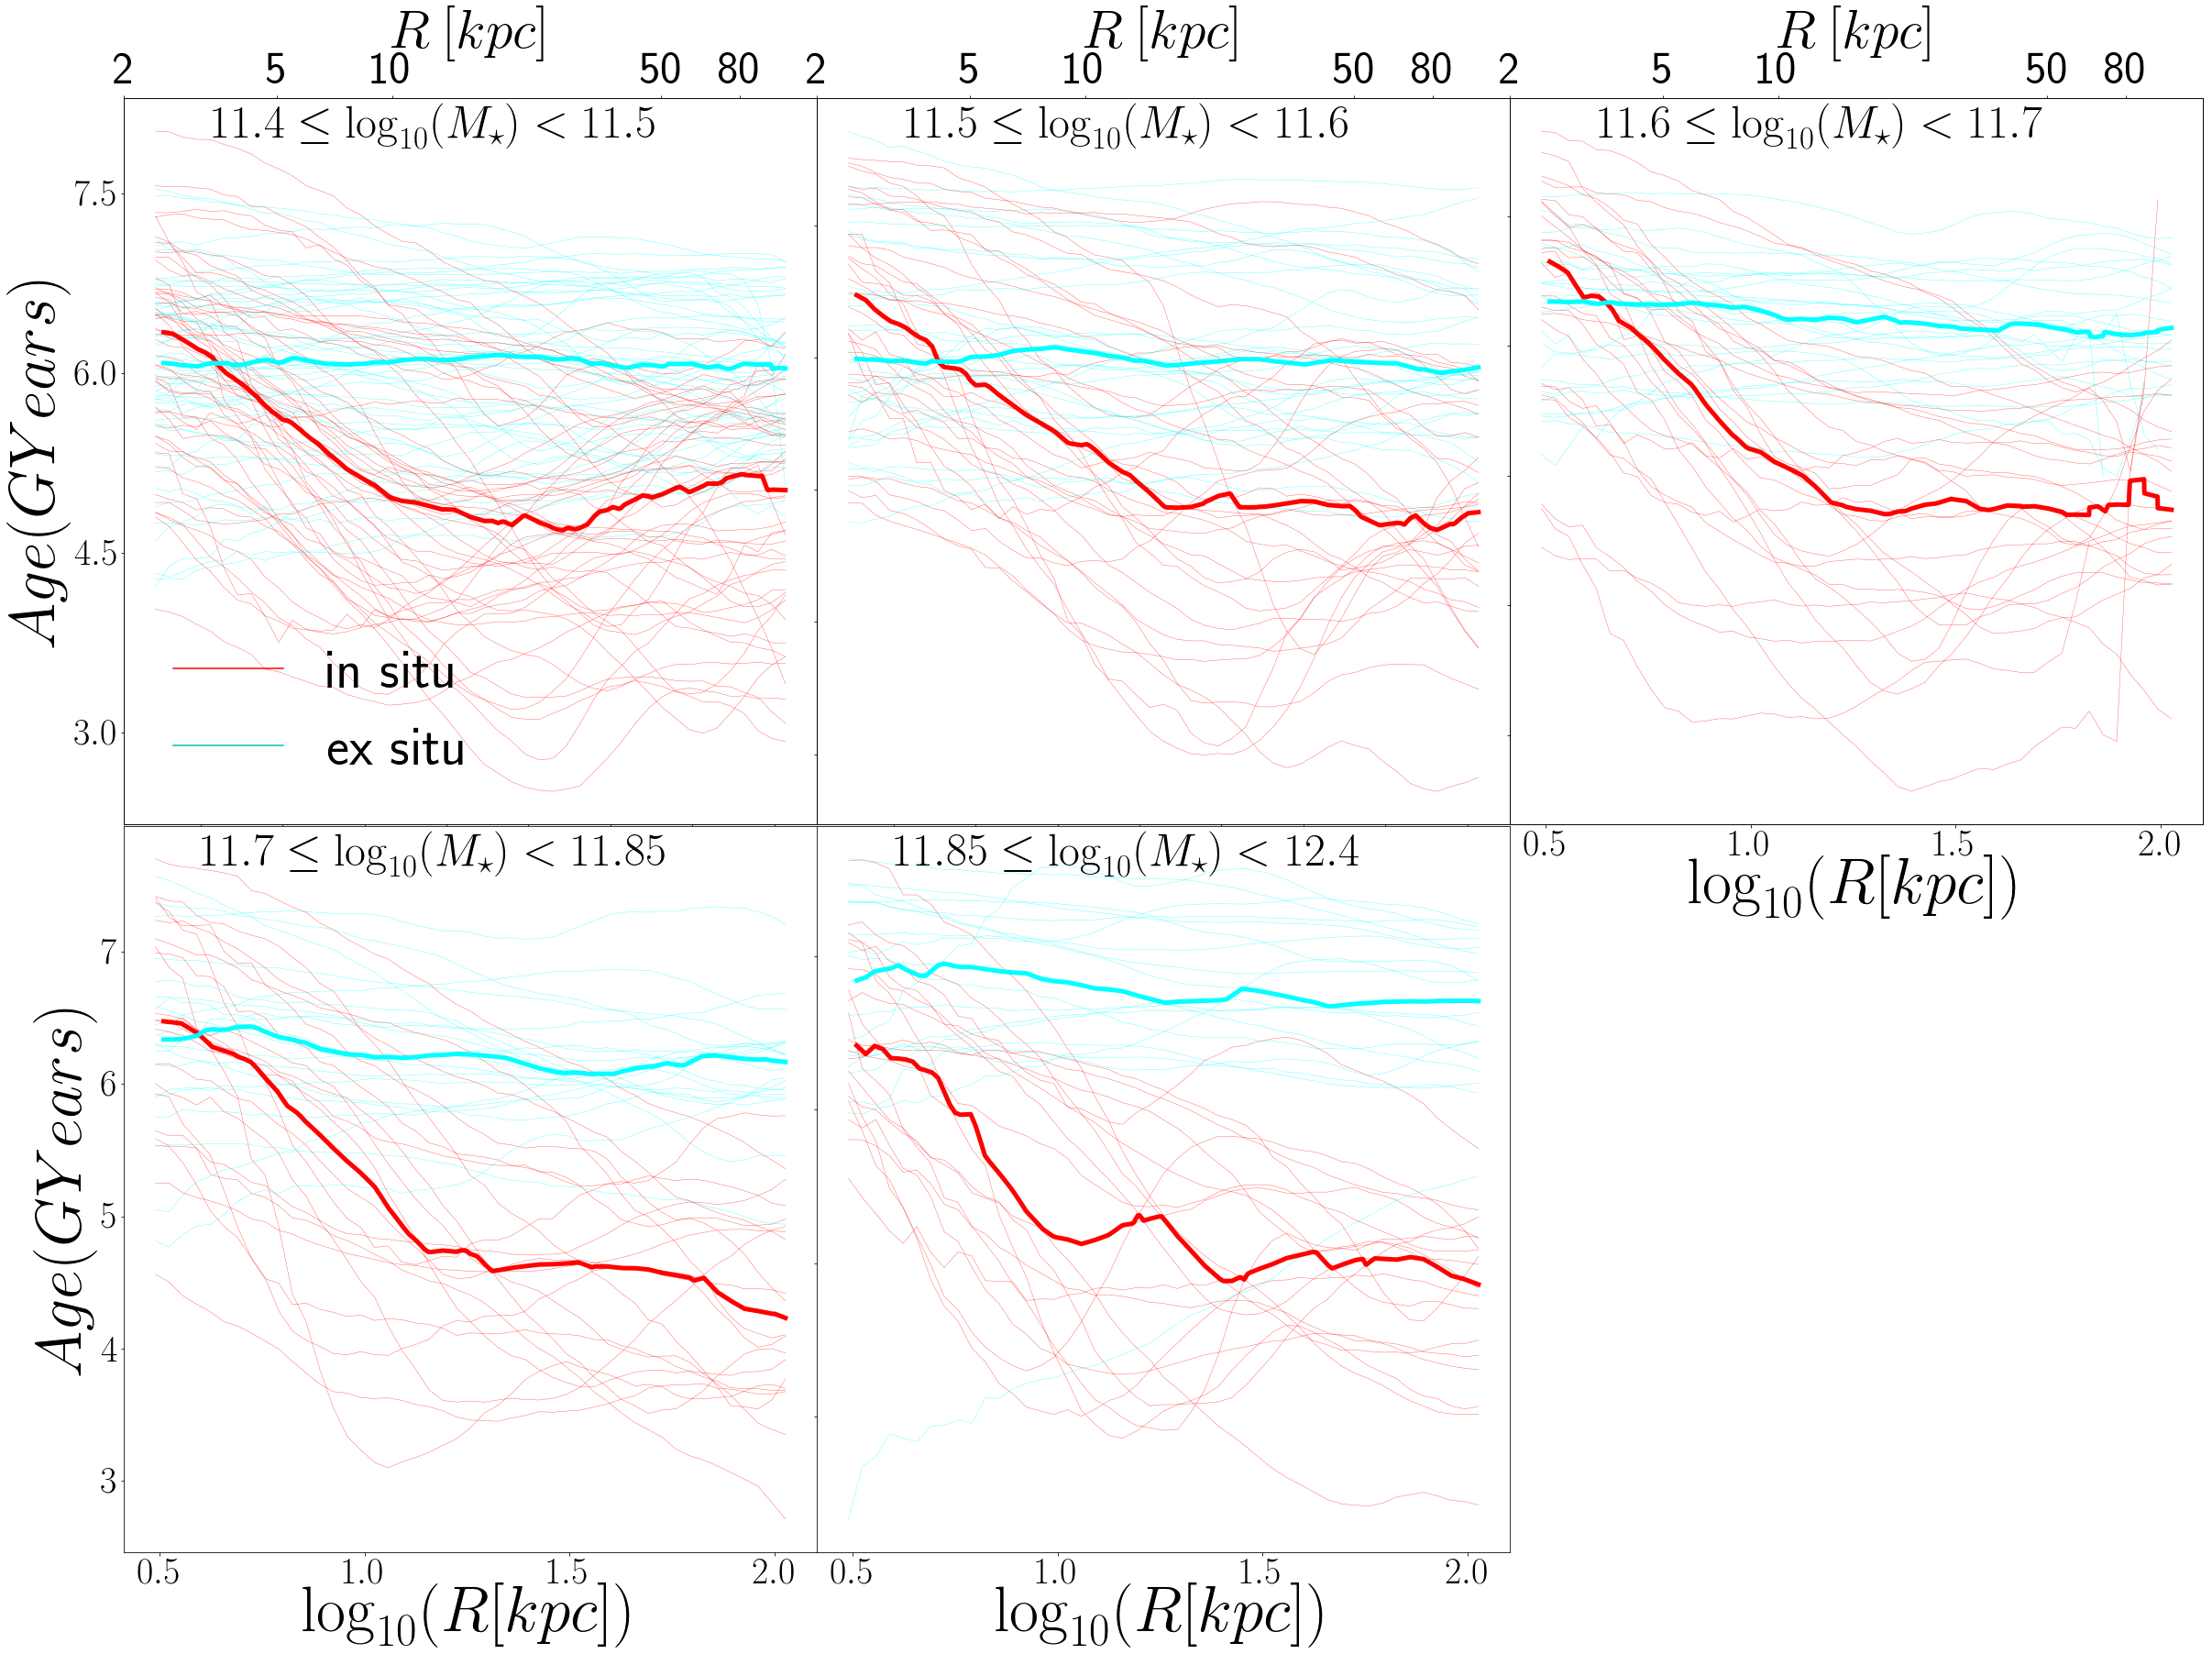

In [214]:
fig = plt.figure(figsize=(35, 22))
ax1 = plt.axes([0.1,0.55,0.3,0.5])
ax2 = plt.axes([0.4,0.55,0.3,0.5])
ax3 = plt.axes([0.7,0.55,0.3,0.5])
ax4 = plt.axes([0.1,0.049,0.3,0.5])
ax5 = plt.axes([0.4,0.049,0.3,0.5])
for i in range(len(age_high_bin_1_maps)):
    if i != 6: # this is because 6 was problematic
        a1,b1,c1 = generate_profiles(age_high_bin_1_maps[i][1],high_bin_1[i],'ell_ins_3')
        #a2,b2,c2 = generate_profiles(age_high_bin_1_maps[i][1],high_bin_1[i],'ell_ins_3')
        a11,b11,c11 = generate_profiles(age_high_bin_1_maps[i][2],high_bin_1[i],'ell_exs_3')
        #a22,b22,c22 = generate_profiles(age_high_bin_1_maps[i][2],high_bin_1[i],'ell_exs_3')
        b1 = np.array(b1)
        b11 = np.array(b11)
        ax1.plot(np.log10(a1),(b1),label = 'metallicity',color = 'r',linewidth = 0.4,alpha = 0.7)
        ax1.plot(np.log10(a11),(b11),label = 'metallicity',color = 'cyan',linewidth = 0.4,alpha = 0.7)
        ax1.set_ylabel(r'$ \log_{10}(\frac{Z}{Z_{\odot}}) $',fontsize = 40)
        ax1.set_xlabel(r'$ \log_{10}(R[kpc]) $',fontsize = 40)
med_bin_1_ins = get_median_am(age_high_bin_1_maps,high_bin_1,'insitu','ell_ins_3')
med_bin_1_exs = get_median_am(age_high_bin_1_maps,high_bin_1,'exsitu','ell_exs_3')
ax1.plot(np.log10(rsma_common),(med_bin_1_ins),label = 'metallicity',color = 'r',linewidth = 5)
ax1.plot(np.log10(rsma_common),(med_bin_1_exs),label = 'metallicity',color = 'cyan',linewidth = 5)


x1, x2 = ax1.get_xlim()
ax1_twin = ax1.twiny()
ax1_twin.set_xlim(x1, x2)
ax1_twin.figure.canvas.draw()
ax1_twin.xaxis.set_ticks([np.log10(2), np.log10(5), np.log10(10), np.log10(50),np.log10(80)])
ax1_twin.xaxis.set_ticklabels([2, 5, 10, 50,80])
ax1_twin.tick_params(axis='both', which='major', labelsize=50)
ax1_twin.set_xlabel(r'$R \: [kpc]$', fontsize=60)
text(0.45, 0.95,'$11.4 \leq \log_{10 }(M_{\star})<11.5$',fontsize =50,
     horizontalalignment='center',
     verticalalignment='center',transform=ax1.transAxes)
red_line = mlines.Line2D([], [], color='r',
                          markersize=15, label='in situ')
cyan_line = mlines.Line2D([], [], color='c',
                          markersize=45, label='ex situ')
ax1.legend(handles=[red_line,cyan_line],loc=3,fontsize =60,frameon=False)
ax1.set_xticklabels([])
ax1.tick_params(axis='y', which='major', labelsize=40)
#ax1.set_xlim(0.5,2.3)
#ax1.set_ylim(2.0,10.1)
#ax1.set_xlabel(r'$\log (R[kpc]) $',fontsize = 40)
ax1.set_ylabel(r'$ Age (G Years) $',fontsize = 70)
ax1.yaxis.set_major_locator(plt.MaxNLocator(6))
#ax1.set_ylim(-0.6,0.47)


for i in range(len(age_high_bin_2_maps)):
    
    a1,b1,c1 = generate_profiles(age_high_bin_2_maps[i][1],high_bin_2[i],'ell_ins_3')
    #a2,b2,c2 = generate_profiles(age_high_bin_1_maps[i][1],high_bin_1[i],'ell_ins_3')
    a11,b11,c11 = generate_profiles(age_high_bin_2_maps[i][2],high_bin_2[i],'ell_exs_3')
        #a22,b22,c22 = generate_profiles(age_high_bin_1_maps[i][2],high_bin_1[i],'ell_exs_3')
    b1 = np.array(b1)
    b11 = np.array(b11)
    ax2.plot(np.log10(a1),(b1),label = 'metallicity',color = 'r',linewidth = 0.4,alpha = 0.7)
    ax2.plot(np.log10(a11),(b11),label = 'metallicity',color = 'cyan',linewidth = 0.4,alpha = 0.7)
        #ax1.set_ylabel(r'$ \log_{10}(\frac{Z}{Z_{\odot}}) $',fontsize = 40)
    ax2.set_xlabel(r'$ \log_{10}(R[kpc]) $',fontsize = 40)
med_bin_2_ins = get_median_am(age_high_bin_2_maps,high_bin_1,'insitu','ell_ins_3')
med_bin_2_exs = get_median_am(age_high_bin_2_maps,high_bin_1,'exsitu','ell_exs_3')
ax2.plot(np.log10(rsma_common),(med_bin_2_ins),label = 'metallicity',color = 'r',linewidth = 5)
ax2.plot(np.log10(rsma_common),(med_bin_2_exs),label = 'metallicity',color = 'cyan',linewidth = 5)
x1, x2 = ax2.get_xlim()
ax2_twin = ax2.twiny()
ax2_twin.set_xlim(x1, x2)
ax2_twin.figure.canvas.draw()
ax2_twin.xaxis.set_ticks([np.log10(2), np.log10(5), np.log10(10), np.log10(50),np.log10(80)])
ax2_twin.xaxis.set_ticklabels([2, 5, 10, 50,80])
ax2_twin.tick_params(axis='both', which='major', labelsize=50)
ax2_twin.set_xlabel(r'$R \: [kpc]$', fontsize=60)

text(0.45, 0.95,'$11.5 \leq \log_{10 }(M_{\star})<11.6$',fontsize =50,
     horizontalalignment='center',
     verticalalignment='center',transform=ax2.transAxes)
#ax2.set_xlim(0.5,2.3)
ax2.set_xticklabels([])
ax2.set_yticklabels([])
#ax2.set_xlabel(r'$\log (R[kpc]) $',fontsize = 30)
#ax2.set_ylabel(r'$\log\ (\mu_{\star}/[M_{\odot}\ \mathrm{kpc}^{-2}])$',fontsize = 50)
#ax2.set_ylim(-0.6,0.47)

for i in range(len(age_high_bin_3_maps)):
    
    a1,b1,c1 = generate_profiles(age_high_bin_3_maps[i][1],high_bin_3[i],'ell_ins_3')
    #a2,b2,c2 = generate_profiles(age_high_bin_1_maps[i][1],high_bin_1[i],'ell_ins_3')
    a11,b11,c11 = generate_profiles(age_high_bin_3_maps[i][2],high_bin_3[i],'ell_exs_3')
        #a22,b22,c22 = generate_profiles(age_high_bin_1_maps[i][2],high_bin_1[i],'ell_exs_3')
    b1 = np.array(b1)
    b11 = np.array(b11)
    ax3.plot(np.log10(a1),(b1),label = 'metallicity',color = 'r',linewidth = 0.4,alpha = 0.7)
    ax3.plot(np.log10(a11),(b11),label = 'metallicity',color = 'cyan',linewidth = 0.4,alpha = 0.7)
        #ax1.set_ylabel(r'$ \log_{10}(\frac{Z}{Z_{\odot}}) $',fontsize = 40)
    ax3.set_xlabel(r'$ \log_{10}(R[kpc]) $',fontsize = 40)
med_bin_3_ins = get_median_am(age_high_bin_3_maps,high_bin_3,'insitu','ell_ins_3')
med_bin_3_exs = get_median_am(age_high_bin_3_maps,high_bin_3,'exsitu','ell_exs_3')
ax3.plot(np.log10(rsma_common),(med_bin_3_ins),label = 'metallicity',color = 'r',linewidth = 5)
ax3.plot(np.log10(rsma_common),(med_bin_3_exs),label = 'metallicity',color = 'cyan',linewidth = 5)
x1, x2 = ax3.get_xlim()
ax3_twin = ax3.twiny()
ax3_twin.set_xlim(x1, x2)
ax3_twin.figure.canvas.draw()
ax3_twin.xaxis.set_ticks([np.log10(2), np.log10(5), np.log10(10), np.log10(50),np.log10(80)])
ax3_twin.xaxis.set_ticklabels([2, 5, 10, 50,80])
ax3_twin.tick_params(axis='both', which='major',  labelsize=50)
ax3_twin.set_xlabel(r'$R \: [kpc]$', fontsize=60)
#ax3.set_ylim(-0.6,0.47)
text(0.45, 0.95,'$11.6 \leq \log_{10 }(M_{\star})<11.7$',fontsize= 50,
     horizontalalignment='center',
     verticalalignment='center',transform=ax3.transAxes)
ax3.set_yticklabels([])
ax3.set_xlabel(r'$\log_{10 } (R[kpc]) $',fontsize = 70)
#ax3.set_ylabel(r'$\log\ (\mu_{\star}/[M_{\odot}\ \mathrm{kpc}^{-2}])$',fontsize = 30)
ax3.tick_params(axis='x', which='major', labelsize=40)

for i in range(len(age_high_bin_4_maps)):
    
    a1,b1,c1 = generate_profiles(age_high_bin_4_maps[i][1],high_bin_4[i],'ell_ins_3')
    #a2,b2,c2 = generate_profiles(age_high_bin_1_maps[i][1],high_bin_1[i],'ell_ins_3')
    a11,b11,c11 = generate_profiles(age_high_bin_4_maps[i][2],high_bin_4[i],'ell_exs_3')
        #a22,b22,c22 = generate_profiles(age_high_bin_1_maps[i][2],high_bin_1[i],'ell_exs_3')
    b1 = np.array(b1)
    b11 = np.array(b11)
    ax4.plot(np.log10(a1),(b1),label = 'metallicity',color = 'r',linewidth = 0.4,alpha = 0.7)
    ax4.plot(np.log10(a11),(b11),label = 'metallicity',color = 'cyan',linewidth = 0.4,alpha = 0.7)
        #ax1.set_ylabel(r'$ \log_{10}(\frac{Z}{Z_{\odot}}) $',fontsize = 40)
    ax4.set_xlabel(r'$ \log_{10}(R[kpc]) $',fontsize = 40)

text(0.45, 0.95,'$11.7 \leq \log_{10 }(M_{\star})<11.85$',fontsize= 50,
     horizontalalignment='center',
     verticalalignment='center',transform=ax4.transAxes)
med_bin_4_ins = get_median_am(age_high_bin_4_maps,high_bin_4,'insitu','ell_ins_3')
med_bin_4_exs = get_median_am(age_high_bin_4_maps,high_bin_4,'exsitu','ell_exs_3')
ax4.plot(np.log10(rsma_common),(med_bin_4_ins),label = 'metallicity',color = 'r',linewidth = 5)
ax4.plot(np.log10(rsma_common),(med_bin_4_exs),label = 'metallicity',color = 'cyan',linewidth = 5)
#ax4.set_xlim(0.5,2.3)
ax4.set_xlabel(r'$\log_{10 } (R[kpc]) $',fontsize = 70)
ax4.set_ylabel(r'$ Age (G Years) $',fontsize = 70)
ax4.tick_params(axis='y', which='major', labelsize=40)
ax4.tick_params(axis='x', which='major', labelsize=40)
ax4.yaxis.set_major_locator(plt.MaxNLocator(6))
#ax4.set_ylim(-0.6,0.47)
for i in range(len(metal_high_bin_5_maps)):
    
    a1,b1,c1 = generate_profiles(age_high_bin_5_maps[i][1],high_bin_5[i],'ell_ins_3')
    #a2,b2,c2 = generate_profiles(age_high_bin_1_maps[i][1],high_bin_1[i],'ell_ins_3')
    a11,b11,c11 = generate_profiles(age_high_bin_5_maps[i][2],high_bin_5[i],'ell_exs_3')
        #a22,b22,c22 = generate_profiles(age_high_bin_1_maps[i][2],high_bin_1[i],'ell_exs_3')
    b1 = np.array(b1)
    b11 = np.array(b11)
    ax5.plot(np.log10(a1),(b1),label = 'metallicity',color = 'r',linewidth = 0.4,alpha = 0.7)
    ax5.plot(np.log10(a11),(b11),label = 'metallicity',color = 'cyan',linewidth = 0.4,alpha = 0.7)
        #ax1.set_ylabel(r'$ \log_{10}(\frac{Z}{Z_{\odot}}) $',fontsize = 40)
    ax5.set_xlabel(r'$ \log_{10}(R[kpc]) $',fontsize = 40)
med_bin_5_ins = get_median_am(age_high_bin_5_maps,high_bin_5,'insitu','ell_ins_3')
med_bin_5_exs = get_median_am(age_high_bin_5_maps,high_bin_5,'exsitu','ell_exs_3')
ax5.plot(np.log10(rsma_common),(med_bin_5_ins),label = 'metallicity',color = 'r',linewidth = 5)
ax5.plot(np.log10(rsma_common),(med_bin_5_exs),label = 'metallicity',color = 'cyan',linewidth = 5)
#ax5.set_ylim(-0.6,0.47)
text(0.45, 0.95,'$11.85 \leq \log_{10 }(M_{\star})<12.4$',fontsize = 50,
     horizontalalignment='center',
     verticalalignment='center',transform=ax5.transAxes)
#ax5.set_xlim(0.5,2.3)
ax5.set_xlabel(r'$\log_{10 } (R[kpc]) $',fontsize = 70)
ax5.tick_params(axis='x', which='major', labelsize=40)
ax5.tick_params(axis='x', which='major', labelsize=40)


#ax5.set_ylabel(r'$\log\ (\mu_{\star}/[M_{\odot}\ \mathrm{kpc}^{-2}])$',fontsize = 30)
ax5.set_yticklabels([])
#ax5.set_xticksize(20)